In [92]:
import pandas as pd
import numpy as np
import plotly.express as px
import duckdb
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

In [52]:
df =  pd.read_csv("./data.csv")

In [75]:
df.shape

(344, 17)

In [66]:
df.iloc[:5]

,studyname,sample_number,species,region,island,stage,individual_id,clutch_completion,date_egg,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,delta_15_n_o_oo,delta_13_c_o_oo,comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [54]:
df.columns = df.columns.str.lower() \
                        .str.replace(' ', '_') \
                        .str.replace('(', '') \
                        .str.replace(')', '') \
                        .str.replace('/', '_')


In [55]:
study_check = duckdb.query("""SELECT studyname,
                                     species, 
                                     count(species) as nb_penguin 
                                FROM df 
                                GROUP BY studyname, species""").to_df()

study_check.pivot(index='studyname', columns='species')

nb_penguin  \
species   Adelie Penguin (Pygoscelis adeliae)   
studyname                                       
PAL0708                                    50   
PAL0809                                    50   
PAL0910                                    52   

                                                     \
species   Chinstrap penguin (Pygoscelis antarctica)   
studyname                                             
PAL0708                                          26   
PAL0809                                          18   
PAL0910                                          24   

                                             
species   Gentoo penguin (Pygoscelis papua)  
studyname                                    
PAL0708                                  34  
PAL0809                                  46  
PAL0910                                  44

The classes are not balanced in the different studies.

The study itself is not a characteristic of penguins so it shoudn't contribute to our decision when we identify the specie of a penguin.

==> We drop this feature.

In [81]:
df.drop(columns=["studyname"], axis=1, inplace=True)

### Check on the feature sample number

In [78]:
duckdb.query("""SELECT species,
                        count(sample_number),
                        count(distinct sample_number),
                        max(distinct sample_number)
                FROM df 
                GROUP BY species""").to_df()

,species,count(sample_number),count(DISTINCT sample_number),max(DISTINCT sample_number)
0,Adelie Penguin (Pygoscelis adeliae),152,152,152
1,Chinstrap penguin (Pygoscelis antarctica),68,68,68
2,Gentoo penguin (Pygoscelis papua),124,124,124


The dataset is divided into three samples based on the species. 

For each group of species, the pinguins are numbered.

The feature sample_number won't help us in our classification problem so we can drop it.

In [79]:
df.drop(columns=["sample_number"], axis=1, inplace=True)

In [82]:
df

,species,region,island,stage,individual_id,clutch_completion,date_egg,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,delta_15_n_o_oo,delta_13_c_o_oo,comments
0,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N38A2,No,12/1/09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N39A1,Yes,11/22/09,46.8,14.3,215.0,4850.0,FEMALE,8.41151,-26.13832,NaN
341,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N39A2,Yes,11/22/09,50.4,15.7,222.0,5750.0,MALE,8.30166,-26.04117,NaN
342,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N43A1,Yes,11/22/09,45.2,14.8,212.0,5200.0,FEMALE,8.24246,-26.11969,NaN


In [86]:
df.region.value_counts()

Anvers    344
Name: region, dtype: int64

All penguins come from the Anvers region. 

The `region` feature doesn't have any valuable information for penguin classification.

We can drop it.

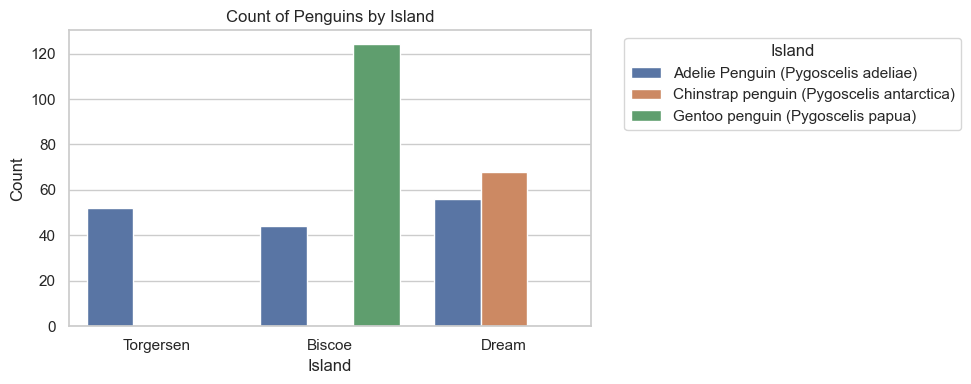

In [98]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='island', hue='species')
plt.title('Count of Penguins by Island')
plt.xlabel('Island')
plt.ylabel('Count')
plt.legend(title='Island', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The `island` feature will be very important for our classification.

- from Torgersen, the specie of the penguin is almost certainly Adelie.

- from Biscoe, the specie of the penguin is almost certainly Adelie or Gentoo.

- from Dream, the specie of the penguin is almost certainly Adelie or Chinstrap.